In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn as nn
import torch
import numpy as np

/usr/bin/my_programs/miniconda3/envs/transformer/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/bin/my_programs/miniconda3/envs/transformer/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/bin/my_programs/miniconda3/envs/trans

In [3]:
def plot_UMAP(generted_expression_profiles, src_expression_profiles):
    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    src_expression_profiles = np.round(src_expression_profiles, decimals=5)
    proj_2d = umap_2d.fit_transform(np.vstack([src_expression_profiles, generted_expression_profiles]))
    n_src = src_expression_profiles.shape[0]
    print(f'n_src: {n_src}')
    fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=True)
    # sample vs generated
    ax[0].scatter(proj_2d[:n_src, 0], proj_2d[:n_src, 1], c='blue', alpha=.5, label='data', s=10)
    ax[0].scatter(proj_2d[n_src:, 0], proj_2d[n_src:, 1], c='yellow', alpha=.5, label='generated', s=10)
    ax[0].legend()
    fig.suptitle(f'umap of binned expression profiles')
    fig.supxlabel('umap 1')
    fig.supylabel('umap 2')
    ax[1].scatter(proj_2d[:n_src, 0], proj_2d[:n_src, 1], alpha=.5, s=10)

    plt.show()

In [4]:
def load_samples(path, n_samples):
    samples = np.load(path)
    print(f'Dataset has shape {samples.shape}')
    return samples[:n_samples], samples[n_samples:]

## Fine tuned model with pretraing

Dataset contains 10000 samples from the endothelial dataset with 200 hvgs and 10000 generated samples. Each generated sample was generated based on a real sample. The Model was fintuned based on a 1628 feature model of the 1,8 Mio heart data set.

In [5]:
samples = np.load('../data/heart_endothelial_200_10000.npy')

In [8]:
print(f'Dataset has shape {samples.shape}')

Dataset has shape (20000, 1628)


In [28]:
real = samples[:10000]
generated = samples[10000:]

All genes beyond the 200 hvgs (gene 201 - gene 1628) should have no expression at all because they are padded.\
*important*: I forgot to mask these paositions during sampleing generartion!

In [29]:
# real data has all zeros for gene 201 - gene 1628
print(np.sum(real[:,200:]))
# generated has predictions in this area
print(np.sum(generated[:,200:]))

0.0
169265307.0


n_src: 10000


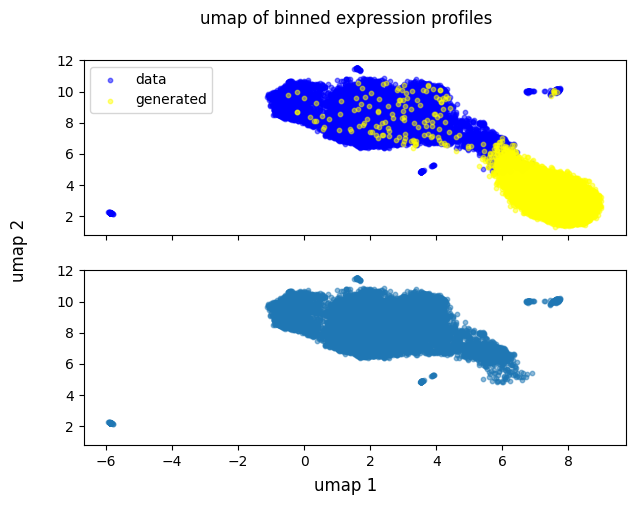

In [34]:
plot_UMAP(generated[:,:200], real[:,:200])

UMAP can cleary separate both population but tehere seem to be an ovelap reagion, als well as generated profiles that lie withing the real sample data points

### Masking in generation process
In this generation run, genes 201 - 1628 were masked during attention computation because they are not in the endothelial dataset

In [2]:
samples = np.load('../data/heart_endothelial_200_10000_fintune_paddedGenesMasked.npy')
print(f'Dataset has shape {samples.shape}')
real = samples[:10000]
generated = samples[10000:]

Dataset has shape (20000, 1628)


In [3]:
# real data has all zeros for gene 201 - gene 1628
print(np.sum(real[:,200:]))
# generated has predictions in this area
print(np.sum(generated[:,200:]))

0.0
112238300.0


Besides masking, the transformer continues to predict values for padded genes

n_src: 10000


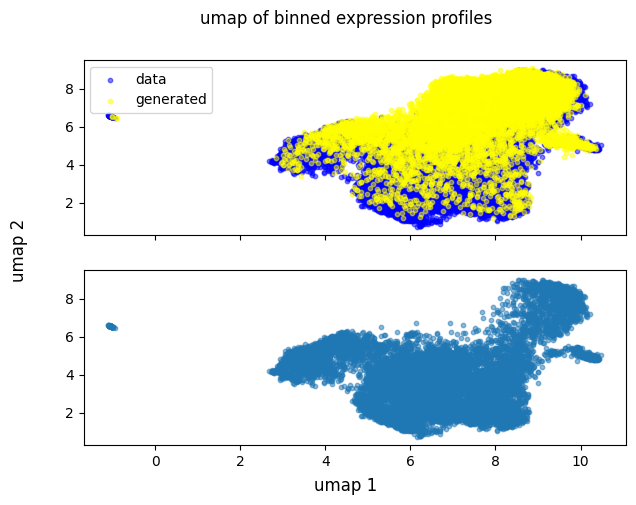

In [6]:
plot_UMAP(generated[:,:200], real[:,:200])

#### Sample sequence

Dataset has shape (20000, 1628)
n_src: 10000


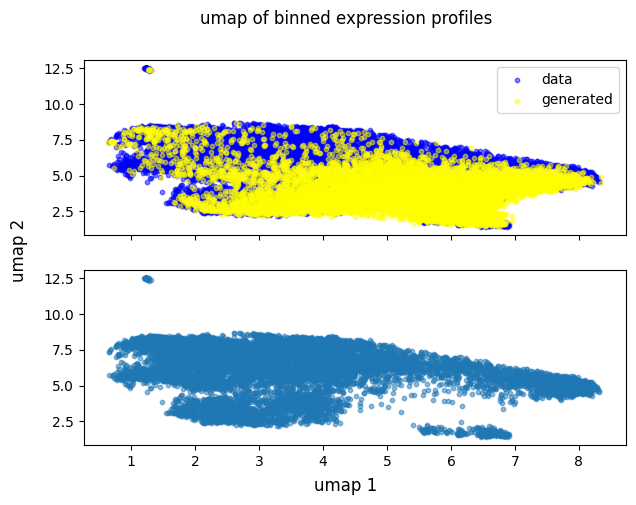

In [19]:
path = '../data/heart_endothelial_200_10000_fintune_paddedGenesMasked_seq.npy'
real, generated = load_samples(path, 10000)
real = real[:,:200]
generated = generated[:,:200]
print(real.shape)
plot_UMAP(generated, real)

## small model no pretraining

A small model was trained to directly fit the endothelial datset. This small model was used to generate 10000 samples based on real samples.

In [37]:
samples = np.load('../data/heart_endothelial_200_10000_nofintune.npy')

In [38]:
print(f'Dataset has shape {samples.shape}')

Dataset has shape (20000, 200)


In [39]:
real = samples[:10000]
generated = samples[10000:]

n_src: 10000


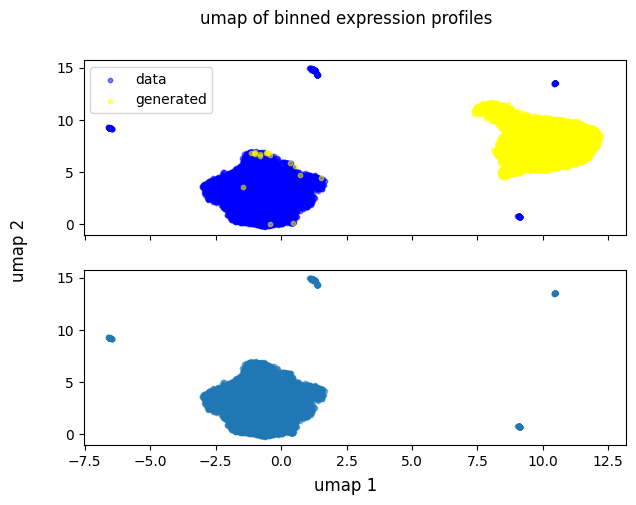

In [40]:
plot_UMAP(generated, real)

The generated and real data samples war clearly separable and are not even linked to each other.

In [10]:
path = '../data/heart_endothelial_200_10000_generationObjective.npy'
real, generated = load_samples(path, 10000)

Dataset has shape (20000, 200)


n_src: 10000


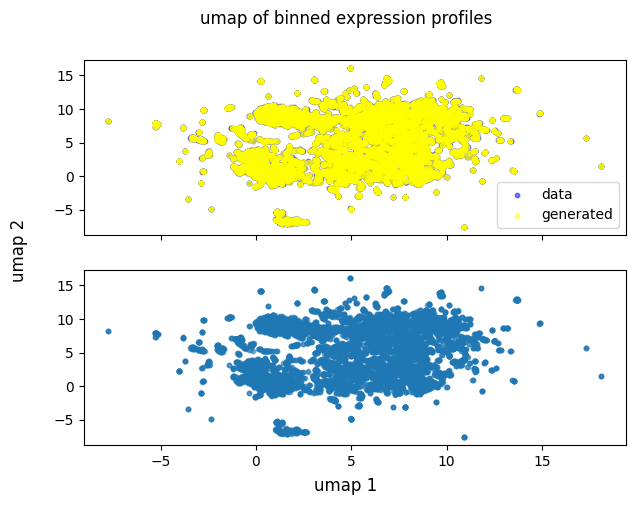

In [11]:
plot_UMAP(generated, real)

The Transformer can reproduce the sample population very well. But this is most likely because the trasnformer did not learn anything but simply memorized the dataset

#### Sample sequence

To check if the Transformer learned anything, I generate a sample sequence in which each generated sample is the input for the next round of geneartion. To compare this I also generated 10000 samples based on 10000 real samples

In [12]:
samples = np.load('../data/heart_endothelial_200_10000_generationObjective_sequence.npy')
real = samples[:10000]
generated = samples[10000:20000]
seq = samples[20000:]

n_src: 10000


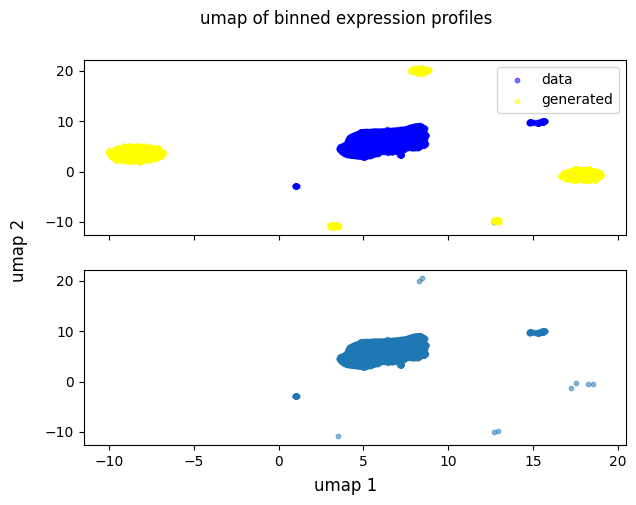

In [17]:
plot_UMAP(seq, real)

n_src: 10000


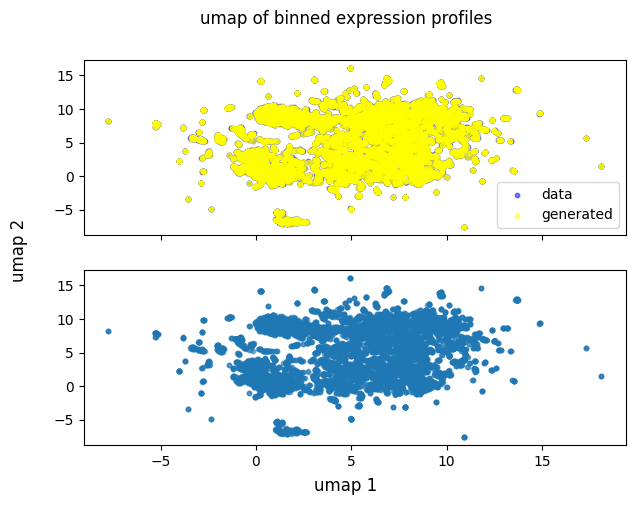

In [18]:
plot_UMAP(generated, real)